In [531]:
import numpy as np
import matplotlib.pyplot as plt
import time
import IPython.display
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor, LongTensor
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable as V
from torch.nn import functional as F
print(torch.__version__)
print(torch.cuda.is_available())

0.4.1
False


the number of data point(original signal): 44100


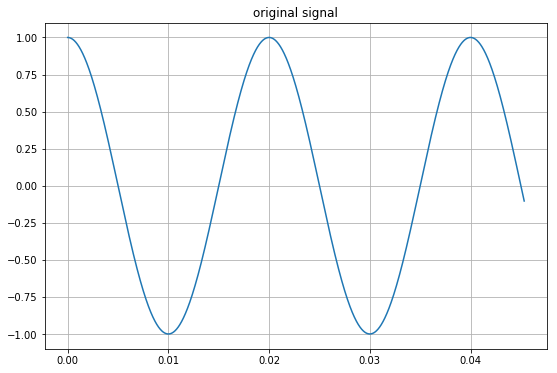

In [532]:
# 学習に使う人工データの生成
sampling_rate = 44100.0 # サンプリング周波数 [Hz]  16000 1秒間
len_seconds = 1.0 # 時間長さ[s]
f_original = 50 # 原信号の周波数
t = np.arange(0, len_seconds, 1 / sampling_rate) # サンプリング点の時間[s]
original_signal = np.cos(2 * np.pi *  f_original * t) # cosで原信号の生成
print('the number of data point(original signal):', len(original_signal))

# 原信号の描画
%matplotlib inline
plt.figure(figsize = (9, 6))
plt.plot(t[:2000], original_signal[:2000])
plt.title('original signal')
plt.grid()
plt.show()

# 原信号の再生
IPython.display.Audio(original_signal, rate=44100)

In [533]:
# ①FM変調
# f_carrierは搬送波の周波数[Hz]、MFDは最大周波数偏移[Hz]
# 参考文献 : http://yyatsuo.com/?p=1635
def freq_mod(original_signal, f_original, f_carrier, MFD):
    vm = np.sin(2*np.pi*f_carrier*t + (MFD/f_original)*np.sin(2*np.pi*f_original*t))
    return vm

the number of data point(frequency modulation signal): 44100


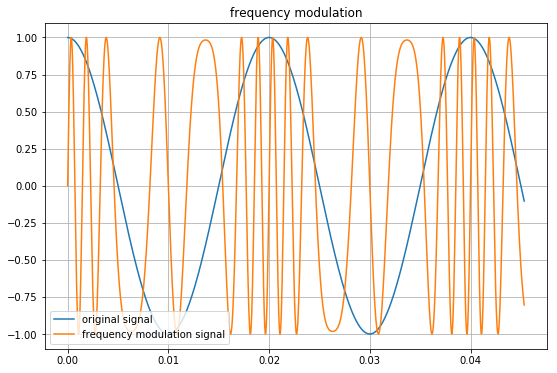

In [534]:
# 搬送波の周波数250 [Hz], 最大周波数偏移 500 [Hz] (一般的でない値？)
fm_signal = freq_mod(original_signal, f_original, 200, 500)
print('the number of data point(frequency modulation signal):', len(fm_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:2000], original_signal[:2000], label = 'original signal')
plt.plot(t[:2000], fm_signal[:2000], label = 'frequency modulation signal')
plt.legend(loc = 'lower left')
plt.title('frequency modulation')
plt.grid()
plt.show()

#FM変調信号の再生
IPython.display.Audio(fm_signal, rate=44100)

In [535]:
# ②AM変調
# f_carrierは搬送波の周波数 [Hz]
def amp_mod(original_signal, f_original, f_carrier):
    vm = np.cos(2*np.pi*f_carrier*t) + (1/2) * (np.cos(2*np.pi*(f_carrier-f_original)*t)+np.cos(2*np.pi*(f_carrier-f_original)*t))
    return vm

the number of data point(amplitude modulation signal): 44100


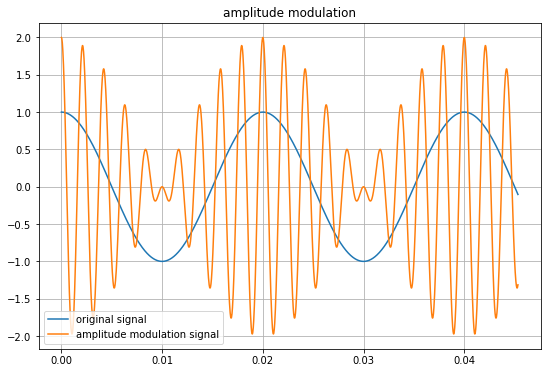

In [536]:
# 搬送波の周波数500 [Hz] （一般的でない値？）
am_signal = amp_mod(original_signal, f_original, 500)
print('the number of data point(amplitude modulation signal):', len(am_signal))
plt.figure(figsize = (9, 6))
plt.plot(t[:2000], original_signal[:2000], label = 'original signal')
plt.plot(t[:2000], am_signal[:2000], label = 'amplitude modulation signal')
plt.legend(loc = 'lower left')
plt.title('amplitude modulation')
plt.grid()
plt.show()

# AM変調信号の再生
IPython.display.Audio(am_signal, rate=44100)

In [537]:
# fm,amの組み合わせ 結局AM、FMどちらかをかけたときとあまり変わらない波形になったのでひとまずコメントアウト
'''
fm_am_signal = freq_mod(amp_mod(original_signal, f_original, 500), f_original, 1000, 2000)
am_fm_signal = amp_mod(freq_mod(original_signal, f_original, 500, 5000), f_original, 1000)
plt.plot(fm_am_signal[:5000])
plt.show()
plt.plot(am_fm_signal[:2000])
plt.show()
'''

'\nfm_am_signal = freq_mod(amp_mod(original_signal, f_original, 500), f_original, 1000, 2000)\nam_fm_signal = amp_mod(freq_mod(original_signal, f_original, 500, 5000), f_original, 1000)\nplt.plot(fm_am_signal[:5000])\nplt.show()\nplt.plot(am_fm_signal[:2000])\nplt.show()\n'

In [538]:
# 決定的な関数は容易に予測できてしまうため、確率的なノイズを付与する
# ホワイトノイズ（ガウシアンノイズによる近似）
def add_noise_whitegauss(signal, std):
    return signal + np.random.normal(0, std, len(signal))

# ピンクノイズ
# 未実装 参考：http://www.firstpr.com.au/dsp/pink-noise/

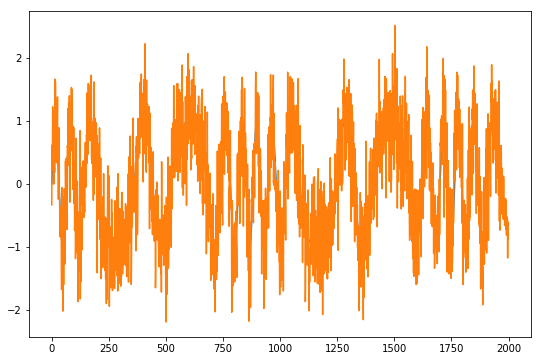

In [539]:
# ノイズの付与
fm_signal_added_whitegauss = add_noise_whitegauss(fm_signal, 0.5)
plt.figure(figsize = (9,6))
plt.plot(fm_signal[:2000])
plt.plot(fm_signal_added_whitegauss[:2000])
plt.show()

In [540]:
# 信号の量子化（符号あり16bit）
def quantize_16bit(signal):
    signal = signal - np.mean(signal)
    quantized_16bit_signal = (signal / np.max(np.abs(signal))*(2**15)).astype(np.int16)
    return quantized_16bit_signal

In [541]:
# 信号の量子化（符号なし8bit）
def quantize_8bit(signal):
    signal = signal - np.mean(signal)
    signal = signal / np.max(np.abs(signal))
    signal = np.round(signal * (2 ** 7 - 1))
    signal = (signal + 127).astype(np.uint8)
    return signal

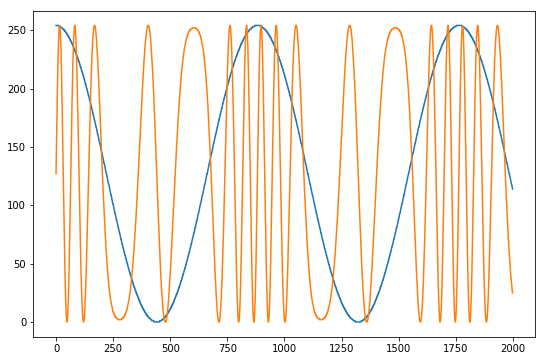

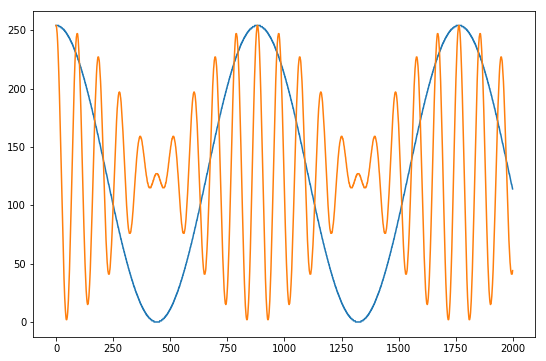

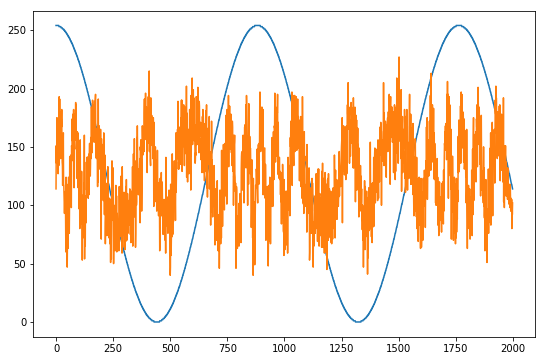

In [542]:
# 取り敢えず0 ～ 255の分類問題にするために量子化（なんか0 ～　254になってしまっている？）
# 原論文では符号あり16bitに量子化された音声データをμ-lawアルゴリズムで8ビット化しているようだが、取り敢えず今回は直接符号なし8ビットに
original_signal_quantized_8bit = quantize_8bit(original_signal)
fm_signal_quantized_8bit = quantize_8bit(fm_signal)
am_signal_quantized_8bit = quantize_8bit(am_signal)
fm_signal_added_whitegauss_quantized_8bit = quantize_8bit(fm_signal_added_whitegauss)
# ノイズなしでやった感じFM変調の方が難しいようなので、取り敢えず今後FM変調中心に進めます

plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(fm_signal_quantized_8bit[:2000])
plt.show()
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(am_signal_quantized_8bit[:2000])
plt.show()
plt.figure(figsize = (9, 6))
plt.plot(original_signal_quantized_8bit[:2000])
plt.plot(fm_signal_added_whitegauss_quantized_8bit[:2000])
plt.show()

In [592]:
# 受容野の広さと信号を受け取り、それに応じたデータセットを作成
# ”受容野の広さ”数分の信号のクラスを入力データ、次の瞬間の信号1つのクラスを出力データとする
N_reception = 32
def make_dataset(signal, n_reception):
    X = []
    Y = []
    for i in range(len(signal) - n_reception):
        X.append(signal[i:i+n_reception])
        Y.append(signal[i+n_reception])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

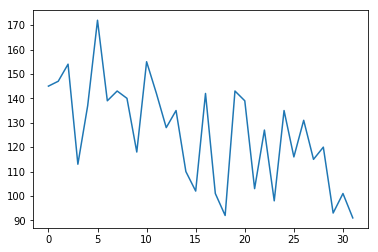

In [593]:
# FM変調信号学習、バリデーションのためのデータセットの準備
'''
X_fm, Y_fm = make_dataset(fm_signal_quantized_8bit, N_reception)
X_fm_train, X_fm_valid, Y_fm_train, Y_fm_valid = train_test_split(X_fm, Y_fm, test_size = 0.2)
ds_fm_train = TensorDataset(Tensor(X_fm_train), LongTensor(Y_fm_train))
ds_fm_valid = TensorDataset(Tensor(X_fm_valid), LongTensor(Y_fm_valid))
fm_train_loader = DataLoader(ds_fm_train, batch_size = 64, shuffle = True)
fm_valid_loader = DataLoader(ds_fm_valid, batch_size = 64, shuffle = False)
'''
X_fm, Y_fm = make_dataset(fm_signal_added_whitegauss_quantized_8bit, N_reception)
X_fm_train, X_fm_valid, Y_fm_train, Y_fm_valid = train_test_split(X_fm, Y_fm, test_size = 0.2)
ds_fm_train = TensorDataset(Tensor(X_fm_train), LongTensor(Y_fm_train))
ds_fm_valid = TensorDataset(Tensor(X_fm_valid), LongTensor(Y_fm_valid))
fm_train_loader = DataLoader(ds_fm_train, batch_size = 64, shuffle = True)
fm_valid_loader = DataLoader(ds_fm_valid, batch_size = 64, shuffle = False)
inp, tar = iter(fm_train_loader).next()
plt.plot(inp[0].numpy())

In [594]:
# AM変調信号学習、バリデーションのためのデータセットの準備
X_am, Y_am = make_dataset(am_signal_quantized_8bit, N_reception)
X_am_train, X_am_valid, Y_am_train, Y_am_valid = train_test_split(X_am, Y_am, test_size = 0.2)
ds_am_train = TensorDataset(Tensor(X_am_train), LongTensor(Y_am_train))
ds_am_valid = TensorDataset(Tensor(X_am_valid), LongTensor(Y_am_valid))
am_train_loader = DataLoader(ds_am_train, batch_size = 64, shuffle = True)
am_valid_loader = DataLoader(ds_am_valid, batch_size = 64, shuffle = False)

In [595]:
# 単なる多層パーセプトロン
class MLP(nn.Module):
    def __init__(self, n_reception, hidden_size, n_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_reception, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, n_classes)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        return out

In [596]:
# CNN
# 出力層サイズ = ((入力層サイズ + 2 * パディング - フィルタサイズ) / ストライド) + 1
class Conv1D(nn.Module):
    def __init__(self, n_classes):
        super(Conv1D, self).__init__()
        self.cv1 = nn.Conv1d(1, 2, kernel_size=2, stride=2, padding=0)
        self.cv2 = nn.Conv1d(2, 4, kernel_size=2, stride=2, padding=0)
        self.cv3 = nn.Conv1d(4, 8, kernel_size=2, stride=2, padding=0)
        self.cv4 = nn.Conv1d(8, 16, kernel_size=2, stride=2, padding=0)
        self.fc = nn.Linear(16, n_classes)
    
    def forward(self, x):
        x = x.view(x.size()[0], 1, x.size()[1])
        out = self.cv1(x)
        out = self.cv2(out)
        out = self.cv3(out)
        out = self.cv4(out)
        out = out.view(out.size()[0], out.size()[1])
        out = self.fc(out)
        return out

torch.Size([64, 32])
tensor(1.0000)


C:\Users\suzuk\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


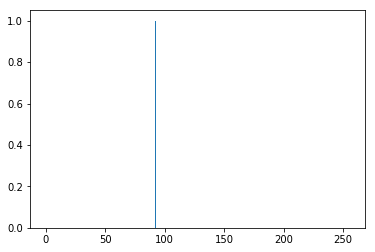

In [611]:
inputs, targets = iter(am_train_loader).next()
print(inputs.size())
net = MLP(N_reception, 128, 256)
pred = net(inputs[12].view(1, N_reception))
pred = F.softmax(pred)
print(torch.sum(pred).data)
pred = pred.view(256)
plt.bar(range(256), pred.data.numpy())
plt.show()

In [488]:
# dilated convolution
class Dilated_Conv1D(nn.Module):
    def __init__(self, n_reception, n_classes):
        super(Dilated_Conv1D, self).__init__()
        Dilation = 1
        self.layers = []
        while Dilation * 2 <= n_reception:
            self.layers.append(nn.Conv1d(Dilation, 2*Dilation, kernel_size=2, stride=1, padding=0, dilation=Dilation))
            # self.layers.append(nn.Conv1d(32, 32, kernel_size=2, stride=1, padding=0, dilation=Dilation))

            Dilation = Dilation * 2
        self.fc = nn.Linear(1 * n_reception, n_classes)
    
    def forward(self, x):
        x = x.view(x.size()[0], 1, x.size()[1])
        for l in self.layers:
            x = F.relu(l(x))
        x = x.view(x.size()[0], x.size()[1])
        out = self.fc(x)
        return out

In [516]:
# dilated convolution
class Dilated_Conv1D_2(nn.Module):
    def __init__(self, n_reception, n_classes):
        super(Dilated_Conv1D_2, self).__init__()
        self.l1 = nn.Conv1d(1, 2, kernel_size=2, stride=1, padding=0, dilation=1)
        self.l2 = nn.Conv1d(2, 4, kernel_size=2, stride=1, padding=0, dilation=2)
        self.l3 = nn.Conv1d(4, 8, kernel_size=2, stride=1, padding=0, dilation=4)
        self.l4 = nn.Conv1d(8, 16, kernel_size=2, stride=1, padding=0, dilation=8)
        self.l5 = nn.Conv1d(16, 32, kernel_size=2, stride=1, padding=0, dilation=16)
        self.l6 = nn.Conv1d(32, 64, kernel_size=2, stride=1, padding=0, dilation=32)
        self.l7 = nn.Conv1d(64, 128, kernel_size=2, stride=1, padding=0, dilation=64)
        self.l8 = nn.Conv1d(128, 256, kernel_size=2, stride=1, padding=0, dilation=128)
        self.l9 = nn.Conv1d(256, 512, kernel_size=2, stride=1, padding=0, dilation=256)
        self.fc = nn.Linear(1 * n_reception, n_classes)
    
    def forward(self, x):
        x = x.view(x.size()[0], 1, x.size()[1])
        out = F.relu(self.l1(x))
        # print(torch.mean(self.l1.weight))
        out = F.relu(self.l2(out))
        # out = F.dropout(out, 0.2)
        out = F.relu(self.l3(out))
        out = F.relu(self.l4(out))
        # out = F.dropout(out, 0.2)
        out = F.relu(self.l5(out))
        # print(torch.mean(self.l5.weight))
        out = F.relu(self.l6(out))
        # out = F.dropout(out, 0.2)
        out = F.relu(self.l7(out))
        out = F.relu(self.l8(out))
        # out = F.dropout(out, 0.5)
        out = F.relu(self.l9(out))
        out = out.view(out.size()[0], out.size()[1])
        out = self.fc(out)
        # print(torch.mean(self.fc.weight))
        return out

In [517]:
# ロス関数、オプティマイザ
# net = MLP(N_reception, 1024, 256)
net = Dilated_Conv1D_2(N_reception, 256)
params = list(net.parameters())
N_params = 0
for p in params:
    N_params += len(p)
print('the number of parameters:', N_params)
if torch.cuda.is_available():
    net.cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005)

the number of parameters: 2556


In [500]:
def train(train_loader):
    net.train()
    running_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = V(inputs)
        targets = V(targets)
        
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        preds = net(inputs)
        loss = loss_fn(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / (i + 1)
    
    return train_loss

In [501]:
def valid(valid_loader):
    net.eval()
    running_loss = 0
    for i, (inputs, targets) in enumerate(valid_loader):
        with torch.no_grad():
            inputs = V(inputs)
            targets = V(targets)
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()
        
            preds = net(inputs)
            loss = loss_fn(preds, targets)
        
        running_loss += loss.data.item()
    
    valid_loss = running_loss / (i + 1)
    
    return valid_loss

In [503]:
# fm変調の学習
losses = []
val_losses = []
n_epoch = 20
start = time.time()
for epoch in range(n_epoch):
    loss = train(fm_train_loader)
    val_loss = valid(fm_valid_loader)
    print('epoch[%d/%d] loss:%1.4f val_loss:%1.4f elasped_time:%4.4f' % (epoch+1, n_epoch, loss, val_loss, time.time() - start))
    
    losses.append(loss)
    val_losses.append(val_loss)
print('elasped_time:%2.4f' % (time.time() - start))

tensor(0.0841, grad_fn=<MeanBackward1>)
tensor(0.0025, grad_fn=<MeanBackward1>)
tensor(-0.0021, grad_fn=<MeanBackward1>)
tensor(0.0841, grad_fn=<MeanBackward1>)
tensor(0.0027, grad_fn=<MeanBackward1>)
tensor(-0.0022, grad_fn=<MeanBackward1>)
tensor(0.0841, grad_fn=<MeanBackward1>)
tensor(0.0029, grad_fn=<MeanBackward1>)
tensor(-0.0023, grad_fn=<MeanBackward1>)
tensor(0.0841, grad_fn=<MeanBackward1>)
tensor(0.0030, grad_fn=<MeanBackward1>)
tensor(-0.0024, grad_fn=<MeanBackward1>)
tensor(0.0842, grad_fn=<MeanBackward1>)
tensor(0.0031, grad_fn=<MeanBackward1>)
tensor(-0.0026, grad_fn=<MeanBackward1>)
tensor(0.0841, grad_fn=<MeanBackward1>)
tensor(0.0031, grad_fn=<MeanBackward1>)
tensor(-0.0027, grad_fn=<MeanBackward1>)
tensor(0.0842, grad_fn=<MeanBackward1>)
tensor(0.0031, grad_fn=<MeanBackward1>)
tensor(-0.0028, grad_fn=<MeanBackward1>)
tensor(0.0842, grad_fn=<MeanBackward1>)
tensor(0.0030, grad_fn=<MeanBackward1>)
tensor(-0.0028, grad_fn=<MeanBackward1>)
tensor(0.0842, grad_fn=<MeanBack

tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0025, grad_fn=<MeanBackward1>)
tensor(-0.0053, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0025, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0025, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0025, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0026, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0026, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0026, grad_fn=<MeanBackward1>)
tensor(-0.0054, grad_fn=<MeanBackward1>)
tensor(0.0840, grad_fn=<MeanBackward1>)
tensor(0.0026, grad_fn=<MeanBackward1>)
tensor(-0.0055, grad_fn=<MeanBackward1>)


KeyboardInterrupt: 

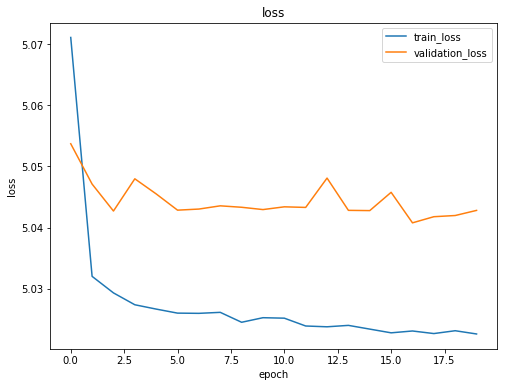

In [549]:
# fm変調のロス表示
plt.figure(figsize = (8,6))
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses, label = 'train_loss')
plt.plot(val_losses, label = 'validation_loss')
plt.legend()
plt.show()

In [518]:
# fm変調のテスト（未来の波形予測）
s_point = 0 # 予測を始めるための初期データの開始地点
n_predict_point = 5000 # 予測するデータ点の数
data_first = fm_signal_added_whitegauss_quantized_8bit[s_point : s_point + N_reception]
data_for_pred = np.copy(data_first)
predicted_data = []
predicted_distribution = []
for i in range(n_predict_point):
    with torch.no_grad():
        inputs = V(Tensor(data_for_pred)).view(1, N_reception)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
        outputs = net(inputs)
        outputs = outputs.view(256)
    predicted_distribution.append(F.softmax(outputs, 0))
    _, pred = torch.max(outputs, 0) 
    pred = pred.item()
    predicted_data.append(pred)
    data_for_pred = np.append(data_for_pred, pred)
    data_for_pred = np.delete(data_for_pred, 0)
predicted_data = np.concatenate([data_first, predicted_data])

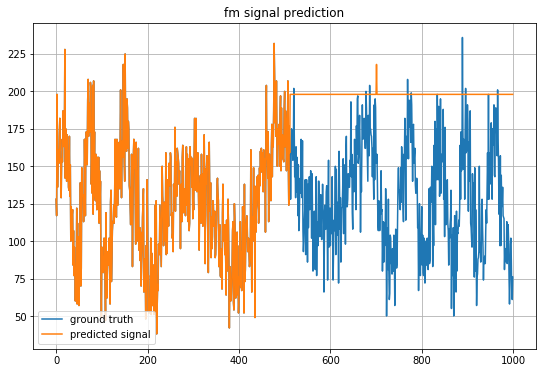

In [519]:
# fm変調のグラフ描画
s_plot = 0 # この点からプロット開始
plt.figure(figsize = (9, 6))
plt.plot(fm_signal_added_whitegauss_quantized_8bit[s_plot + s_point : s_plot + s_point + 1000], label = 'ground truth')
plt.plot(predicted_data[s_plot:s_plot + 1000], label = 'predicted signal')
plt.legend(loc = 'lower left')
plt.title('fm signal prediction')
plt.grid()
plt.show()

max_predict 96
max_target 96


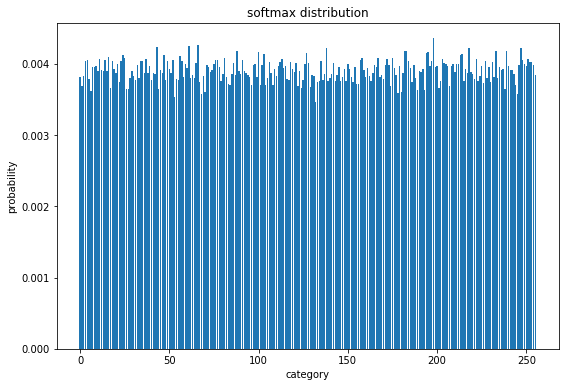

0.00015179542


In [523]:
index = 100
plt.figure(figsize = (9,6))
plt.title('softmax distribution')
plt.xlabel('category')
plt.ylabel('probability')
plt.bar(range(256), predicted_distribution[index].cpu().numpy())
print('max_predict', predicted_data[index])
print('max_target', fm_signal_added_whitegauss_quantized_8bit[index])
plt.show()
print(np.std(predicted_distribution[index].cpu().numpy()))